In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'My_AI4Top/Top-invar-DL'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(GOOGLE_DRIVE_PATH)

drive/My Drive/My_AI4Top/Top-invar-DL


In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

In [5]:
import torch
if torch.cuda.is_available:
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Please set GPU via Edit -> Notebook Settings')

Good to go


In [ ]:
%%time
from Superfluid_Generator_v3 import *
import numpy as np
from joblib import Parallel, delayed
#torch.set_printoptions(sci_mode=False)
device = 'cuda'
B_steps = 25
mu_steps = 25
mu_random = 10 
winding_array = torch.tensor([1,2])
winding_unique = winding_array.shape[0]
winding_batch = 1
winding_per_num = 1
winding_total = winding_batch*winding_per_num
Delta = torch.ones(1,1) # Delta(x,y)
D_total = torch.zeros(winding_unique*winding_total,mu_random,Delta.shape[0],Delta.shape[1],mu_steps,B_steps)
D_total_trivial = torch.zeros(1*winding_total,mu_random,Delta.shape[0],Delta.shape[1],mu_steps,B_steps)
labels = torch.zeros(winding_unique*mu_random)
a_div_b = 1
B = torch.linspace(-5,5,steps=B_steps)
mu = torch.zeros(winding_unique+1,mu_random)
mu_offset_array = torch.linspace(-5,5,steps=mu_steps)
mu_div = 1 #divide mu to 10 trucks
mu_truck = mu_random//mu_div
#Here a function computing total D

for w in range(winding_unique+1):
  #mu[w] = torch.from_numpy(np.random.uniform(-30,30,mu_random)).to(torch.float32)
  mu[w] = torch.arange(0,10,1)

def winding_function(i):
  '''
  Compute Superfluid stiffness for each truck
  ''' 
  mu_local = mu[:,i*mu_truck:(i+1)*mu_truck]
  D_generator = Superfluid_stiffness(Kn_cut=1000,Kn_num=10000,winding_array=winding_array,winding_num=winding_per_num,B=B,mu=mu_local[:-1],mu_offset_array=mu_offset_array,Delta=Delta,a_div_b=1,device=device)
  D_generator_trivial = Superfluid_stiffness_trivial(Kn_cut=1000,Kn_num=10000,winding_num=winding_per_num,B=B,mu=mu_local[-1:],mu_offset_array=mu_offset_array,Delta=Delta,a_div_b=1,device=device)
  D_total[:,i*mu_truck:(i+1)*mu_truck,:,:,:,:] = D_generator.total().to(device='cpu')
  D_total_trivial[:,i*mu_truck:(i+1)*mu_truck,:,:,:,:] = D_generator_trivial.total().to(device='cpu')
  torch.cuda.empty_cache()

Parallel(n_jobs=-1,require='sharedmem')(delayed(winding_function)(i) for i in range(mu_div))


labels = torch.cat( (winding_array.repeat_interleave(mu_random).reshape(-1,1),mu[:-1].reshape(-1,1)),dim=1)
labels_trivial = torch.cat((torch.zeros(1*winding_total).repeat_interleave(mu_random).reshape(-1,1),mu[-1:].reshape(-1,1)),dim=1)

D_total = torch.cat((D_total_trivial,D_total),dim=0)
labels = torch.cat((labels_trivial,labels),dim=0)
print(D_total.shape)
print(labels.shape)


torch.Size([3, 10, 1, 1, 25, 25])
torch.Size([30, 2])
CPU times: user 193 ms, sys: 305 ms, total: 498 ms
Wall time: 1.61 s


In [ ]:
mu_matrix = mu.reshape(mu.shape[0],mu.shape[1],1)+mu_offset_array.reshape(1,1,-1)
R_mu = (mu_matrix).reshape(mu_matrix.shape[0],mu_matrix.shape[1],1,1,1,mu_matrix.shape[2],1).to(device)

### Re-normalize D_total 

In [ ]:
D_total = D_total.reshape((winding_unique+1)*mu_random,B_steps,mu_steps)

In [ ]:
vmax = torch.max(D_total)
vmin = torch.min(D_total)
print(vmax,vmin)

tensor(4.5424) tensor(-0.6527)


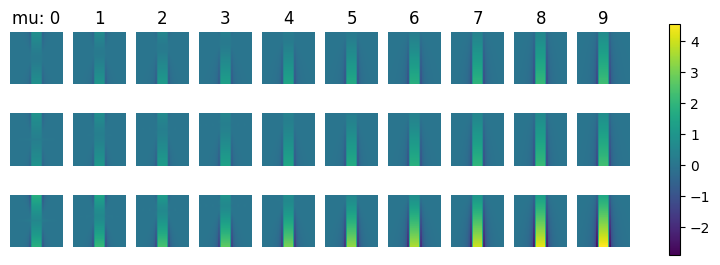

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(winding_unique+1,mu_random)
fig.set_figwidth(mu_random)
fig.set_figheight(winding_unique+1)
ax = ax.flatten()
vmax = torch.max(D_total)
vmin = torch.min(D_total)
for i in range((winding_unique+1)*mu_random):
    im = ax[i].imshow(D_total[i],vmin=vmin,vmax=vmax)
    if i%(winding_unique+1) == 0:
        ax[i].set_ylabel(f'n: {labels[i,0].item():.0f}')
    if i< mu_random:
      if i == 0:
        ax[i].set_title(f'mu: {labels[i,1].item():.0f}')
      else:
        ax[i].set_title(f'{labels[i,1].item():.0f}')
    ax[i].axis('off')
plt.colorbar(im,ax=ax)
plt.show()
    


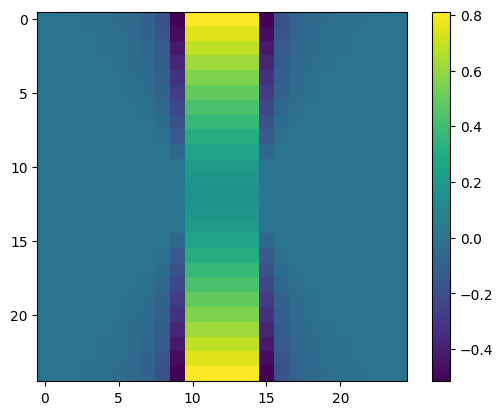

In [ ]:
plt.imshow(D_total[0])
plt.colorbar()

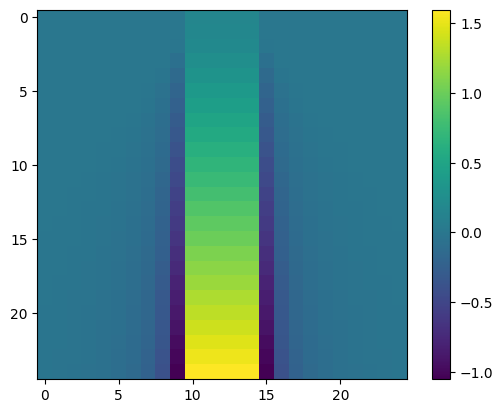

In [ ]:
plt.imshow(D_total[5])
plt.colorbar()

### Plot Graphene Data

In [6]:
import os
Graphene_D_path = os.path.join(GOOGLE_DRIVE_PATH,'Graphene_D.pt')
Graphene_labels_path = os.path.join(GOOGLE_DRIVE_PATH,'Graphene_label.pt')
Graphene_D = torch.load(Graphene_D_path)
Graphene_labels = torch.load(Graphene_labels_path)


In [7]:
print(Graphene_D.shape)
print(Graphene_D.max())
print(Graphene_D.min(),torch.argwhere(Graphene_D<-10))

torch.Size([2121, 1, 25, 25])
tensor(6.8935)
tensor(-1.6229) tensor([], size=(0, 4), dtype=torch.int64)


In [ ]:
print(Graphene_D[3,0,12,9],Graphene_D[4,0,12,9])

tensor(-21264.8320) tensor(0.4119)


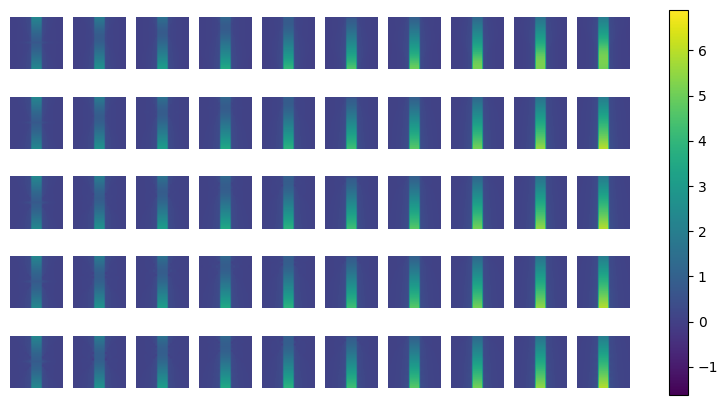

In [8]:
import matplotlib.pyplot as plt 
#t_unique = 21
t_unique = 21
mu_random = 101
Graphene_D = Graphene_D.reshape(t_unique,mu_random,25,25)
t_show = 5
mu_show = 10
fig, ax = plt.subplots(t_show,mu_show)
fig.set_figwidth(mu_show)
fig.set_figheight(t_show)

# vmax = 5
# vmin = -5
vmax = torch.max(Graphene_D).item()
vmin = torch.min(Graphene_D).item()
for i in range(t_show):
  for j in range(mu_show):
    im = ax[i,j].imshow(Graphene_D[5*i,10*j],vmax=vmax,vmin=vmin)
    #im = ax[j].imshow(Graphene_D[t_show*i,j],vmax=vmax,vmin=vmin)

    ax[i,j].axis('off')
    # if i == 0: #first row
    #   fig.text(i,j,f'{Graphene_labels[5*i*10*j,1].item():.1f}')
    # if j == 0: #first col:
    #   fig.text(i,j,f'{Graphene_labels[5*i*10*j,0].item():.1f}')

plt.colorbar(im,ax=ax)
plt.show()

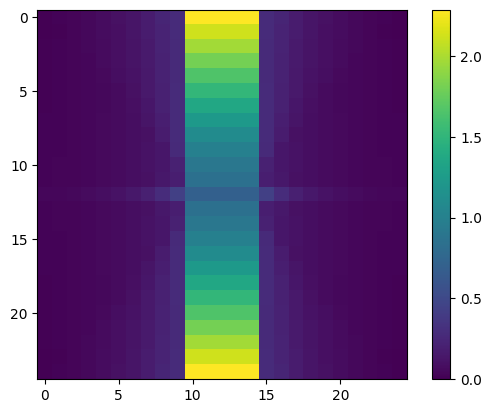

In [ ]:
plt.imshow(Graphene_D[0,0])
plt.colorbar()

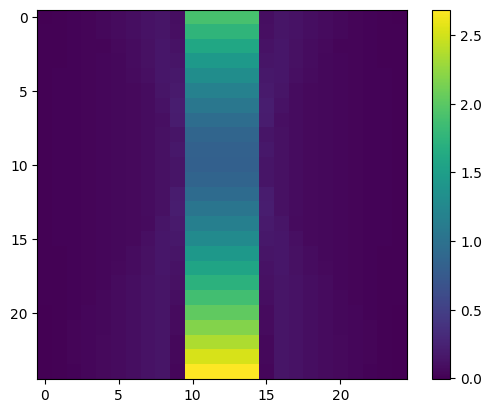

In [ ]:
plt.imshow(Graphene_D[0,10])
plt.colorbar()

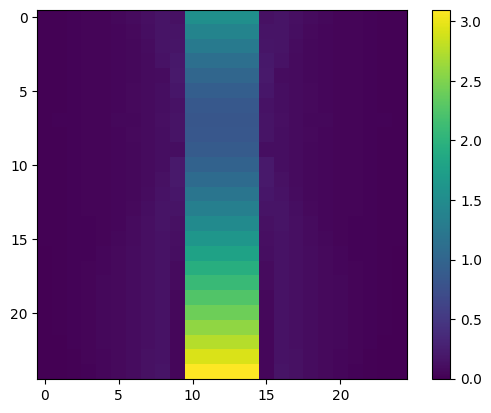

In [ ]:
plt.imshow(Graphene_D[0,20])
plt.colorbar()

In [ ]:
from Superfluid_Generator_v3 import *
import torch 
import math
x = torch.linspace(-10,10,500)
y = (x*Lorentzian(x,eta=0.0000001)).sum()
print(y)

tensor(1.4211e-14)


In [ ]:
(20/500)**2/math.e

0.0005886071058743078

In [ ]:
A = torch.arange(0,9).reshape(3,3)
#A = [1,2,3,4]
index = torch.argmax(A,dim=1,keepdim=True)
print(index)
print(A.gather(1,index))


tensor([[2],
        [2],
        [2]])
tensor([[2],
        [5],
        [8]])


In [ ]:
k_cut = 1000
k_num = 10000
Kn = torch.linspace(0,k_cut,k_num).reshape(1,1,1,1,1,1,k_num)
mu = 5
Delta = 1
B = torch.tensor([1.5,-5]).reshape(1,1,1,1,1,-1,1)
#eta = k_cut/k_num*40
E_plus = ((Kn + mu)**2 + Delta**2).sqrt()
E_minus = ((Kn - mu)**2 + Delta**2).sqrt()

index_p = torch.argmin(abs(E_plus-abs(B)),dim=-1,keepdim=True)
index_m = torch.argmin(abs(E_minus-abs(B)),dim=-1,keepdim=True)
print(index.shape)
print(Kn.expand_as(E_plus-abs(B)).gather(-1,index))
K_min_plus = torch.linspace(-k_cut/k_num/2,k_cut/k_num/2,k_num).expand_as(E_plus-abs(B)) + Kn.expand_as(E_plus-abs(B)).gather(-1,index_p).expand_as(E_plus-abs(B))

K_min_minus = torch.linspace(-k_cut/k_num/2,k_cut/k_num/2,k_num).expand_as(E_minus-abs(B)) + Kn.expand_as(E_minus-abs(B)).gather(-1,index_m).expand_as(E_minus-abs(B))

E_min_plus =  ((K_min_plus + mu)**2 + Delta**2).sqrt()
E_min_minus =  ((K_min_minus - mu)**2 + Delta**2).sqrt()

eta = k_cut/k_num/k_num *10
y = ( K_min_plus/E_min_plus**2*Lorentzian(E_min_plus - abs(B),eta=eta) +K_min_minus/E_min_minus**2* Lorentzian(E_min_minus-abs(B), eta=eta) ).mean(dim=-1)*(k_cut/k_num)
#print(y,B**2/torch.sqrt(B**2-1))
print(y/(4*torch.pi),2/abs(B)/(4*torch.pi),2/abs(B)/((B**2-Delta**2).sqrt())*abs(mu)/(4*torch.pi))
print(2*eta/(k_cut/k_num/k_num))
print(E_min_plus)

torch.Size([1, 1, 1, 1, 1, 2, 1])
tensor([[[[[[[2.0002],
             [5.7006]]]]]]])
tensor([[[[[[0.2898, 0.0003]]]]]]) tensor([[[[[[[0.1061],
             [0.0318]]]]]]]) tensor([[[[[[[0.4745],
             [0.0325]]]]]]])
20.0
tensor([[[[[[[5.0500, 5.0500, 5.0500,  ..., 5.1480, 5.1480, 5.1481],
             [5.0500, 5.0500, 5.0500,  ..., 5.1480, 5.1480, 5.1481]]]]]]])


In [ ]:
k_cut = 3
k_num = 10000
Kn = torch.linspace(0,k_cut,k_num)
mu = 0
Delta = 1
B = 2
eta = k_cut/k_num*20
E_plus = ((Kn + mu)**2 + Delta**2).sqrt()

y = (E_plus*Lorentzian(E_plus - B,eta=eta)).mean()*(k_cut)
print(y,B**2/math.sqrt(2**2-1))
print(2*eta/(k_cut/k_num))
print(E_min_plus)

tensor(2.3028) 2.3094010767585034
40.0
tensor([1.9295, 1.9295, 1.9295,  ..., 2.0157, 2.0157, 2.0157])


In [ ]:
k_cut = 100
k_num = 10000
x = torch.linspace(-k_cut,k_cut,k_num)
mu = 0
eta = k_cut/k_num*25
E_plus = 6-5*x**5
y = (E_plus*Lorentzian(x,eta=eta)).mean()*2*k_cut
print(y)

tensor(5.9763)
